In [10]:
from build_circuit import build_circuit
import numpy as np


distance = 3
    
p_meas = 1e-3
p_gate = 1e-3
p_idle = 0.0
p_cnot = 1e-3

n_trials = 1000

Instructions = [
    ("H", [0]),
    ("CX", [0, 1]),
    ("M", [0,1]),
]

circ = build_circuit(distance=distance, rounds=distance, p_gate=p_gate, 
                     p_meas=p_meas, p_idle=p_idle, p_cnot=p_cnot, instructions=Instructions)


Successfully created clean circuit...
Successfully applied noise to the circuit...


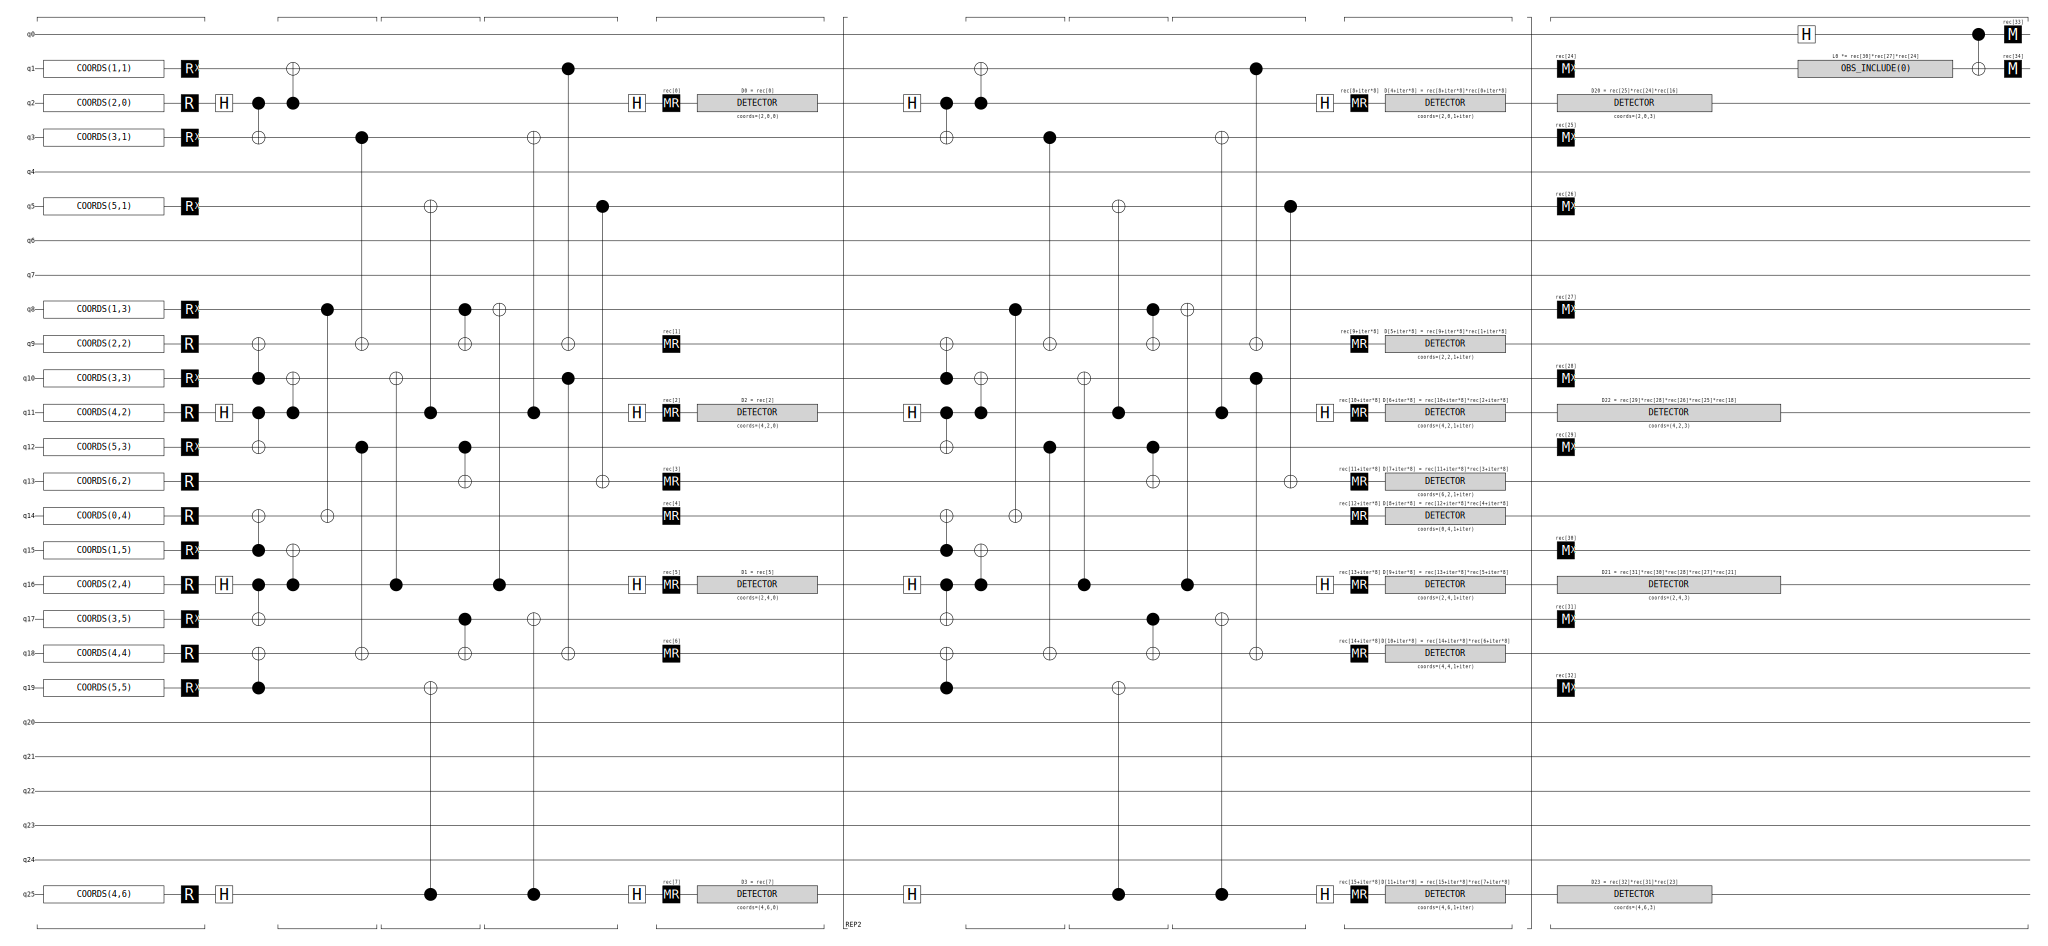

In [11]:
circ.diagram('timeline-svg')

In [12]:
import stim 
import numpy as np

In [ ]:
import numpy as np
import stim

def create_clean_circuit(distance: int, rounds: int) -> stim.Circuit:
    """Create a clean surface code circuit."""
    return stim.Circuit.generated(
        "surface_code:rotated_memory_x",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=0,
        after_reset_flip_probability=0,
        before_measure_flip_probability=0,
        before_round_data_depolarization=0
    )

def apply_noise_manual(circuit: stim.Circuit, p_gate: float, p_meas: float, p_idle: float, p_cnot: float) -> stim.Circuit:
    """Apply manual noise."""
    # FIX 1: Flatten the circuit to remove loops so we can process instruction-by-instruction
    circuit = circuit.flattened()
    
    noisy_circuit = stim.Circuit()
    
    single_qubit_gates = {"H", "R", "RX", "RY", "RZ"}
    two_qubit_gates = {"CX", "CNOT", "CZ"}
    measure_gates = {"M", "MX", "MY", "MZ"}

    num_qubits = circuit.num_qubits

    for instruction in circuit:
        noisy_circuit.append(instruction)
        
        # Skip annotations (TICK, SHIFT_COORDS)
        if not instruction.name: 
            continue

        targets = instruction.targets_copy()
        # Filter for actual integer qubit targets only
        target_indices = [t.value for t in targets if t.is_qubit_target]

        if instruction.name in measure_gates:
            if p_meas > 0:
                noisy_circuit.append("X_ERROR", target_indices, p_meas)
            if p_idle > 0:
                idle_qubits = [q for q in range(num_qubits) if q not in target_indices]
                if idle_qubits:
                    noisy_circuit.append("DEPOLARIZE1", idle_qubits, p_idle)

        elif instruction.name in single_qubit_gates:
            if p_gate > 0:
                noisy_circuit.append("DEPOLARIZE1", target_indices, p_gate)

        elif instruction.name in two_qubit_gates:
            if p_cnot > 0:
                noisy_circuit.append("DEPOLARIZE2", target_indices, p_cnot)
    
    return noisy_circuit

def combine_circuits_parallel(circ1: stim.Circuit, circ2: stim.Circuit) -> stim.Circuit:
    """
    Combines two circuits to run simultaneously side-by-side.
    """
    # FIX 2: Flatten both circuits to unroll loops (REPEAT blocks)
    circ1 = circ1.flattened()
    circ2 = circ2.flattened()

    shift = circ1.num_qubits
    
    # Calculate the Observable shift
    obs_shift = 0
    for instr in circ1:
        if instr.name == "OBSERVABLE_INCLUDE":
            args = instr.gate_args_copy()
            if args:
                obs_shift = max(obs_shift, int(args[0]) + 1)

    # Re-build circ2 with shifted indices
    circ2_shifted = stim.Circuit()
    for instr in circ2:
        new_targets = []
        for t in instr.targets_copy():
            if t.is_qubit_target:
                new_targets.append(t.value + shift)
            elif t.is_x_target:
                new_targets.append(stim.target_x(t.value + shift))
            elif t.is_y_target:
                new_targets.append(stim.target_y(t.value + shift))
            elif t.is_z_target:
                new_targets.append(stim.target_z(t.value + shift))
            elif t.is_combiner:
                new_targets.append(stim.target_combiner())
            else:
                new_targets.append(t)
        
        # Shift the observable index
        new_args = instr.gate_args_copy()
        if instr.name == "OBSERVABLE_INCLUDE":
            if new_args:
                new_args[0] += obs_shift
                
        circ2_shifted.append(instr.name, new_targets, new_args)

    # Merge them TICK by TICK
    full_circuit = stim.Circuit()
    iter1 = iter(circ1)
    iter2 = iter(circ2_shifted)
    
    # Simple zipper merge
    while True:
        chunk1 = stim.Circuit()
        try:
            while True:
                op = next(iter1)
                chunk1.append(op)
                if op.name == "TICK": 
                    break
        except StopIteration:
            pass

        chunk2 = stim.Circuit()
        try:
            while True:
                op = next(iter2)
                chunk2.append(op)
                if op.name == "TICK": 
                    break
        except StopIteration:
            pass

        if len(chunk1) == 0 and len(chunk2) == 0:
            break
            
        for op in chunk1:
            if op.name != "TICK": 
                full_circuit.append(op)
        for op in chunk2:
            if op.name != "TICK": 
                full_circuit.append(op)
            
        full_circuit.append("TICK")

    return full_circuit

# --- Execution ---

distance = 3
rounds = 1

# 1. Create patches
patch_left = create_clean_circuit(distance, rounds)
patch_right = create_clean_circuit(distance, rounds)

# 2. Combine (flattening happens inside here now)
combined_clean = combine_circuits_parallel(patch_left, patch_right)
print(f"Combined Qubits: {combined_clean.num_qubits}")

# 3. Noise
final_circuit = apply_noise_manual(combined_clean, p_gate=1e-3, p_meas=1e-3, p_idle=0, p_cnot=1e-5)

# 4. Simulate
sampler = final_circuit.compile_detector_sampler()

# Run 1000 shots
shots = 1000
observables = sampler.sample(shots=shots)

# Count logical errors
errors_left = np.sum(observables[:, 0])
errors_right = np.sum(observables[:, 1])

print(f"\nSimulated {shots} shots.")
print(f"Logical Errors (Left Patch): {errors_left} / {shots}")
print(f"Logical Errors (Right Patch): {errors_right} / {shots}")

Combined Qubits: 52

Simulated 1000 shots.
Logical Errors (Left Patch): 513 / 1000
Logical Errors (Right Patch): 489 / 1000


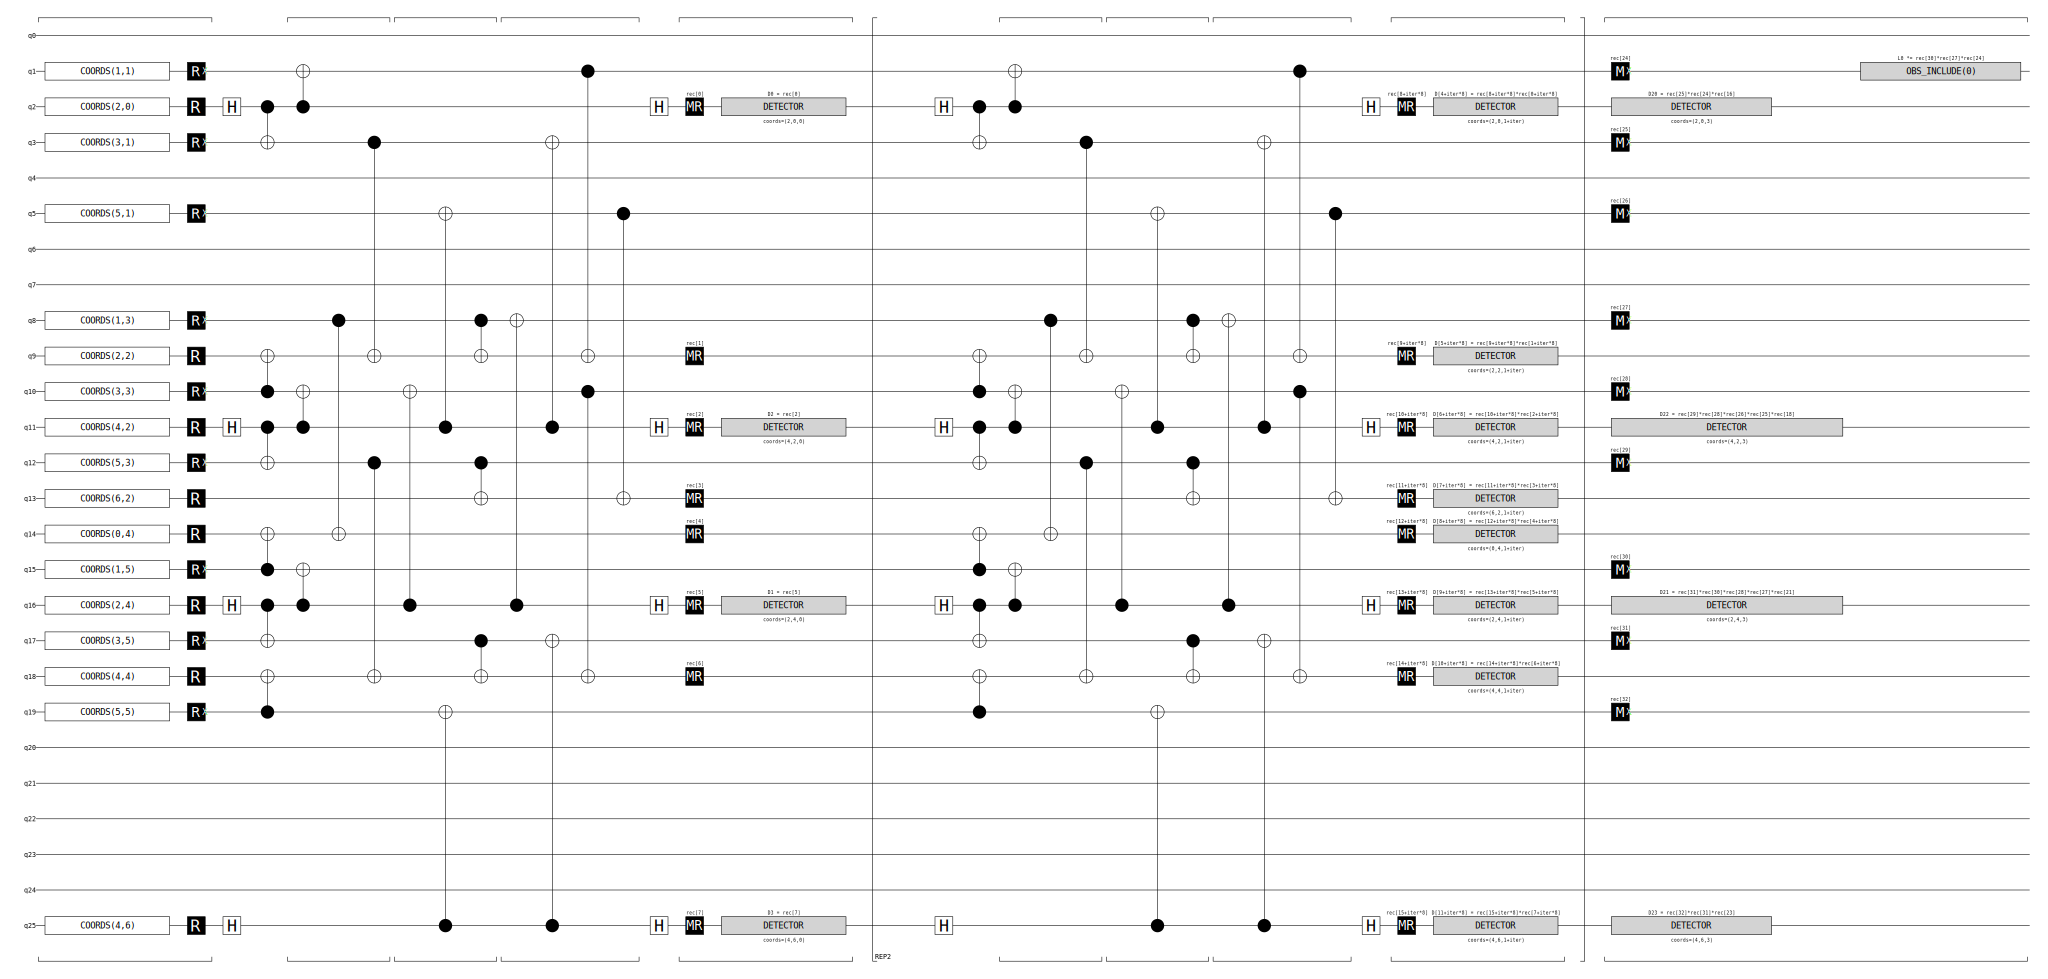

In [1]:
import stim
import numpy as np
from build_circuit import build_circuit, create_clean_circuit, apply_noise
from combine_circuits import combine_circuits_parallel


distance = 3
rounds = distance
p_meas = 1e-3
p_gate = 1e-3
p_idle = 0
p_cnot = 0

Instructions_on_logical_bits = [
    ("H", [0]),
    ("CX", [0, 1]),
    ("M", [0,1]),
]
# Two logical qubits
left_q = create_clean_circuit(distance, rounds)
right_q = create_clean_circuit(distance, rounds)

# Create combined clean circuit
combined_clean = combine_circuits_parallel(left_q, right_q)

# left_q.diagram('timeline-svg')
right_q.diagram('timeline-svg')
# Has to build 2 independent circuits and combine them in parallel
# I need to encode somehow how the gates are applied in each circuit and how to build
# the 2 qubit gates across circuits (or rather how that is done in the combined circuit)
# which should be just applying CNOT across the shifted indices
# circ = build_circuit() # type:ignore 

# So I still need a function that performs the operations on the logical qubits/patches

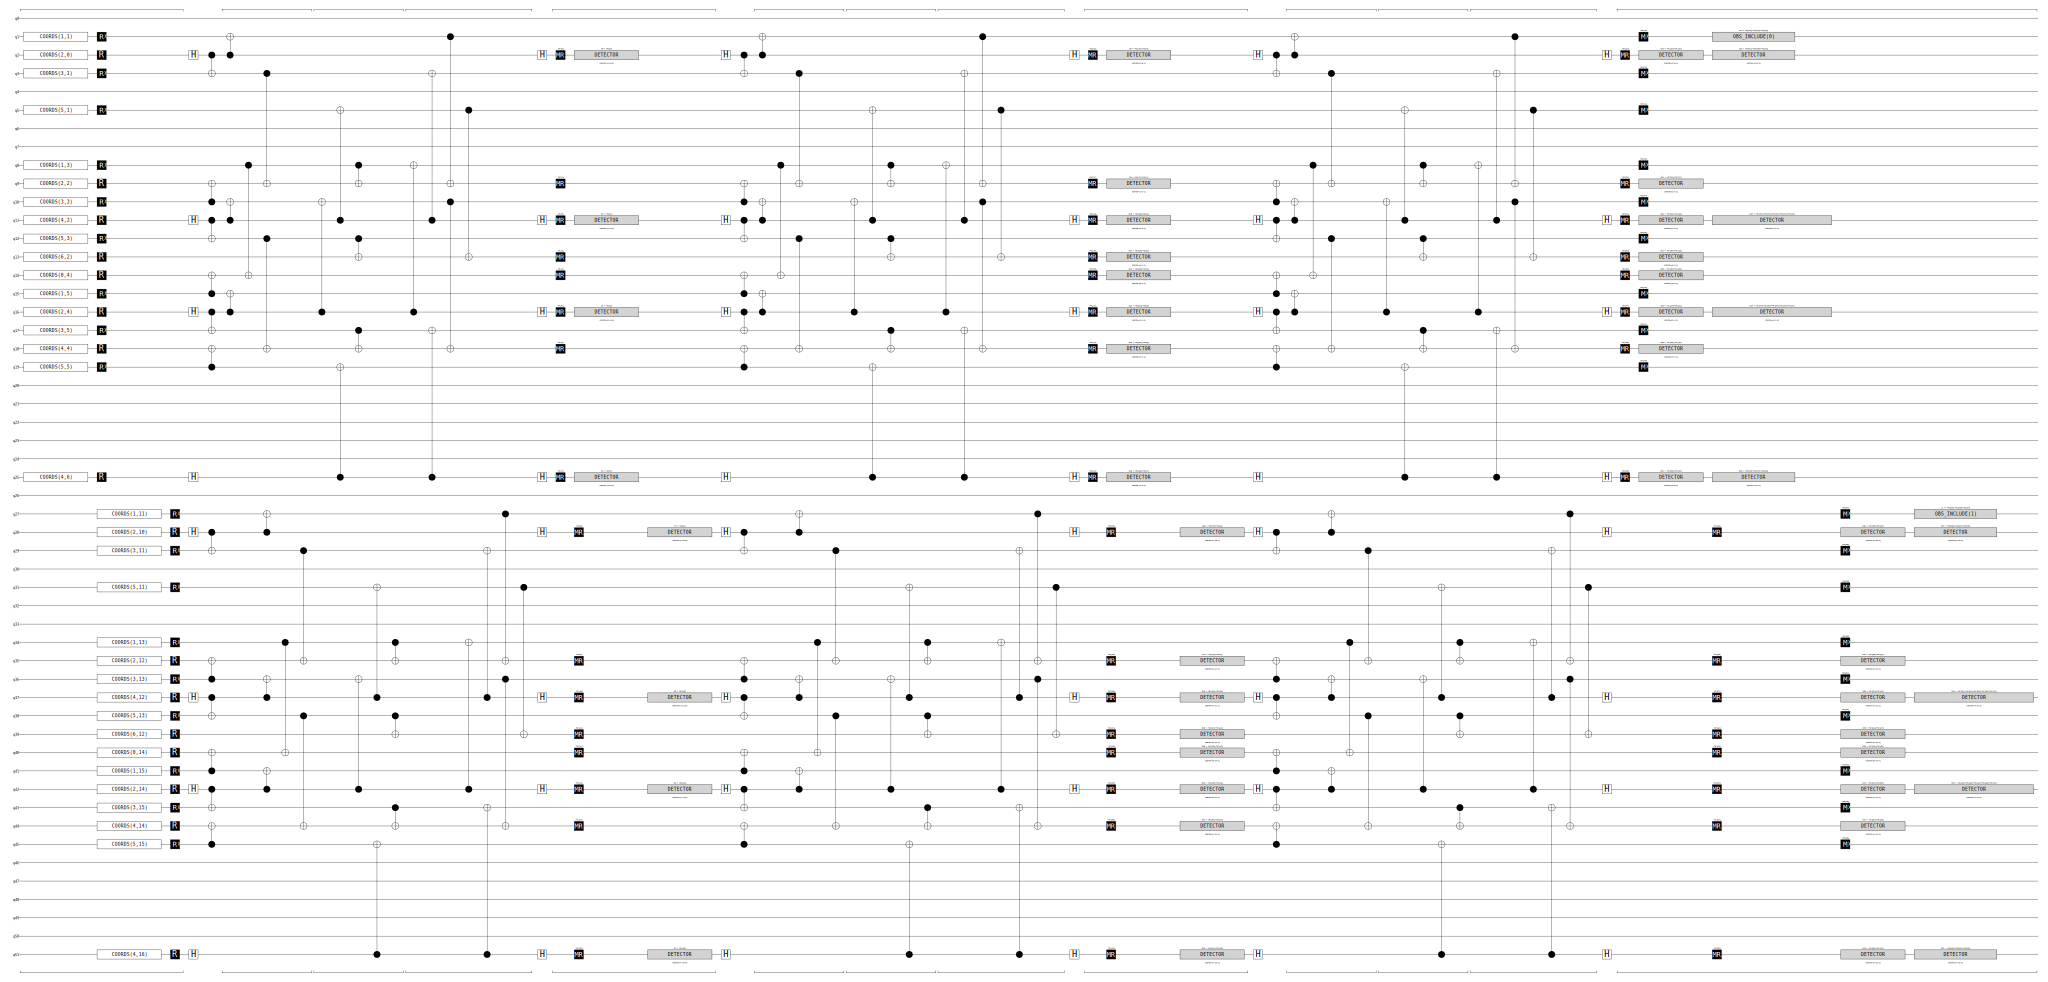

In [2]:
combined_clean.diagram('timeline-svg')

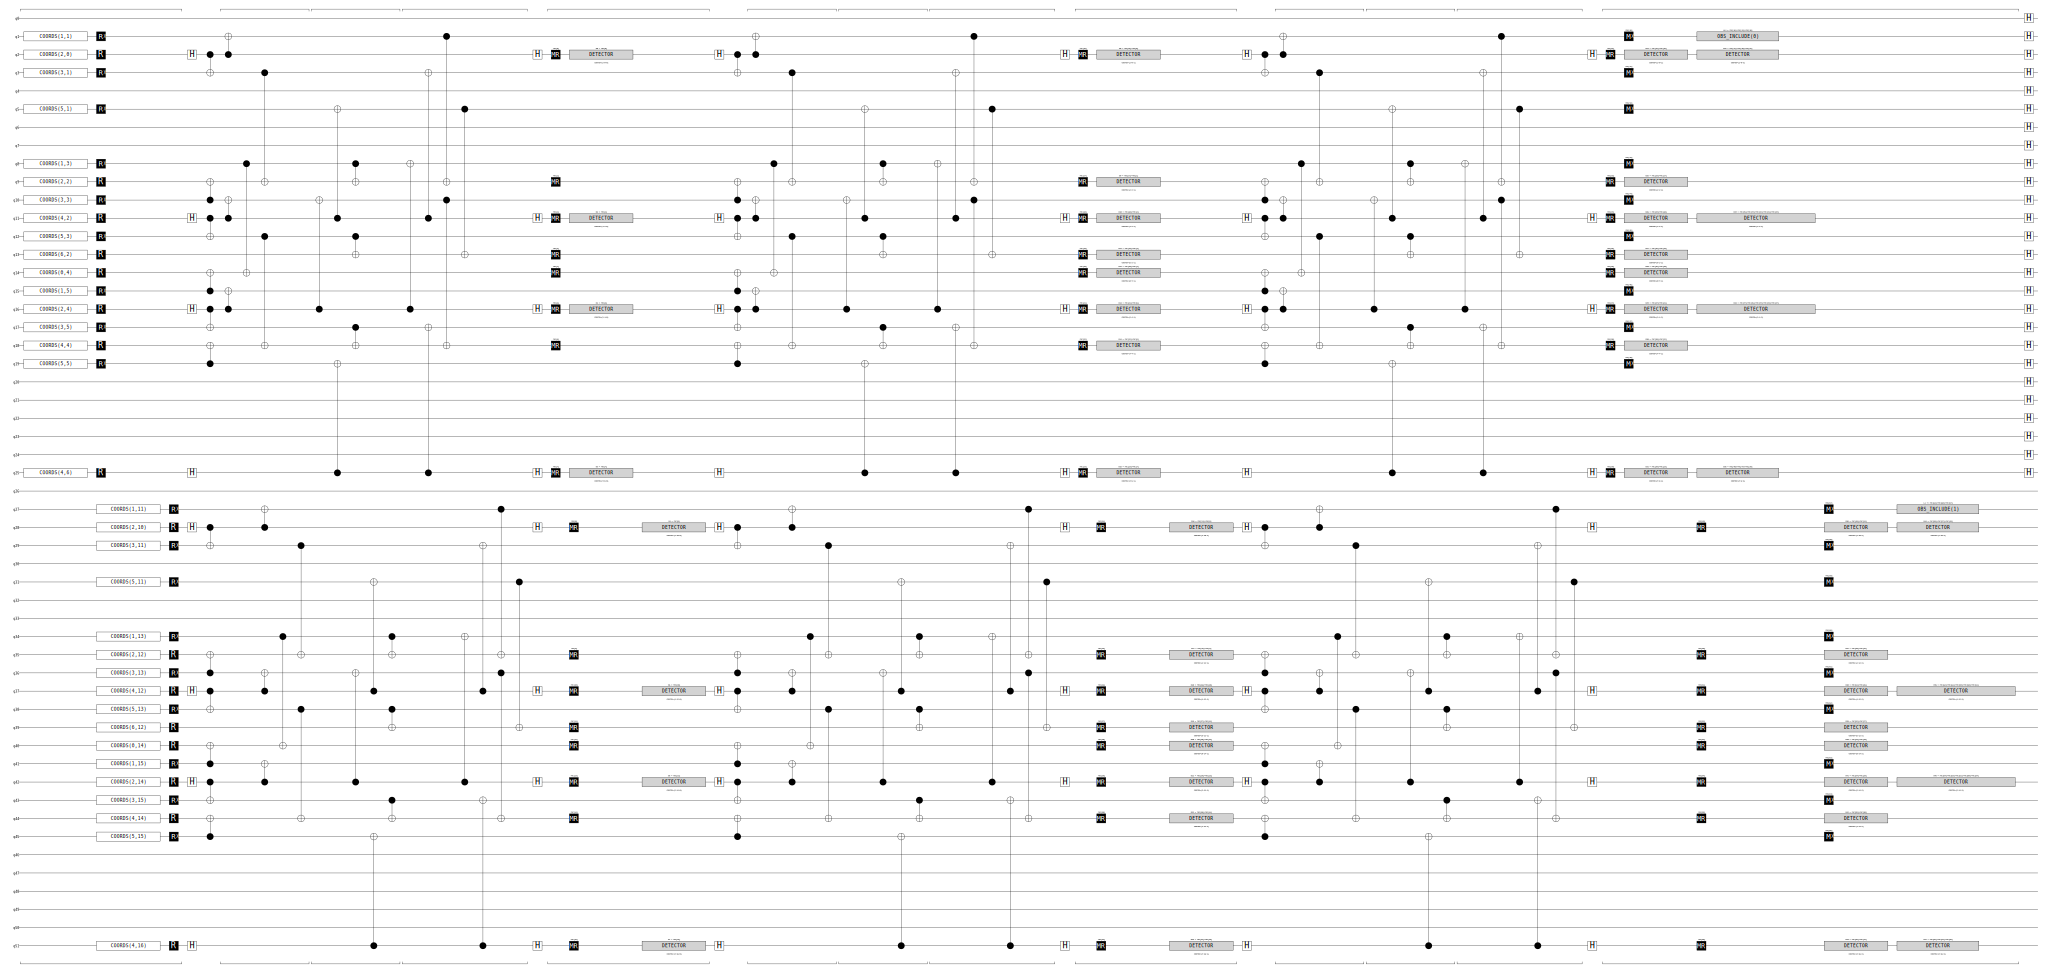

In [3]:
# Apply hadamard on logical qubit 0
for target in range(combined_clean.num_qubits//2):
    combined_clean.append("H", [target])  # type: ignore

combined_clean.diagram('timeline-svg')

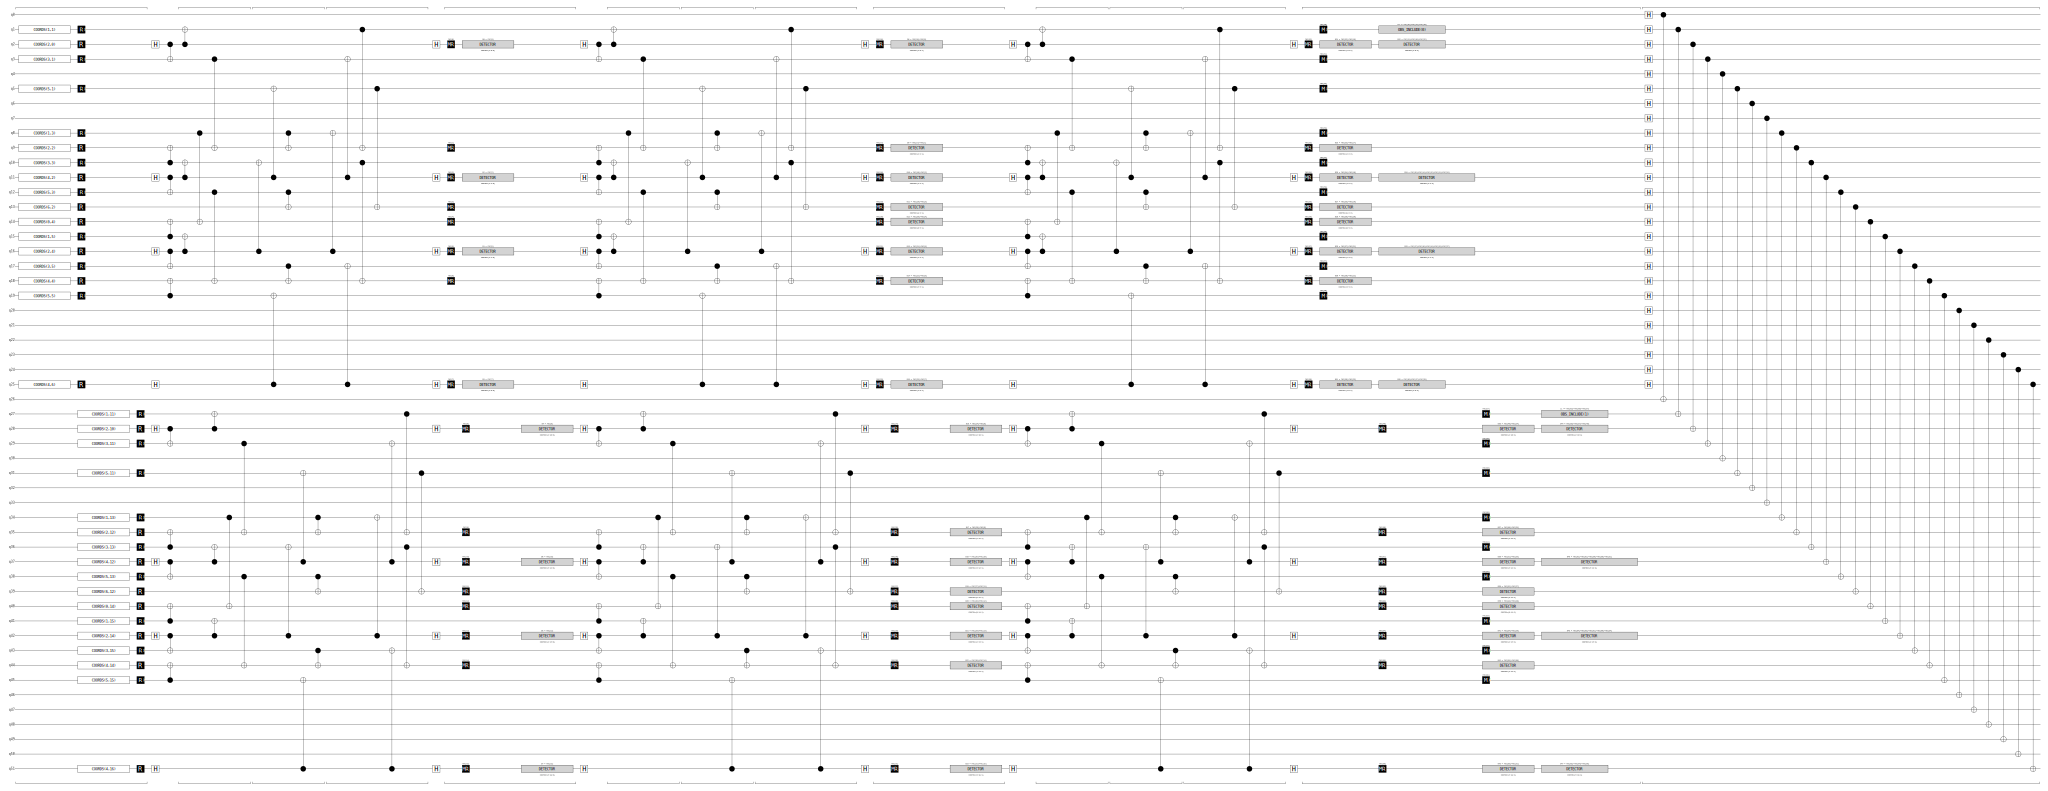

In [4]:
# Now apply CNOT between logical qubit 0 and 1
for target in range(combined_clean.num_qubits//2):
    combined_clean.append("CX", [target, target + combined_clean.num_qubits//2])  # type: ignore
combined_clean.diagram('timeline-svg')

In [23]:
from calendar import c


distance = 3
rounds = distance
p_meas = 0 # No internal noise for this test
p_gate = 0
p_idle = 0
p_cnot = 0
p_logical_x_flip = 0.20 # 20% X error rate for the logical test

# Two logical qubits (Surface Code D=3, X-memory)
left_q = create_clean_circuit(distance, rounds)
right_q = create_clean_circuit(distance, rounds)

# Create combined circuit (two parallel D=3 codes)
combined_clean = combine_circuits_parallel(left_q, right_q)
num_data_qubits_per_code = left_q.num_qubits

# Apply logical H on Qubit 0 (Transversal H on all data qubits of first code)
# The Hadamard is transversal for the X-basis memory code
combined_clean.append("H", range(num_data_qubits_per_code))  # type: ignore

# Apply logical CNOT (Control Q0, Target Q1)
# Transversal CNOT between data qubits at corresponding indices
targets = []
for i in range(num_data_qubits_per_code):
    targets.extend([i, i + num_data_qubits_per_code])

combined_clean.append("CX", targets)  # type: ignore


# --- Error Injection and Final Measurement ---

# 1. Inject 20% X flip error immediately before the final measurement
# This models a final measurement/depolarization error
combined_clean.append("X_ERROR", range(combined_clean.num_qubits), p_logical_x_flip)

# 2. Add a final round of stabilization (or simply a pause for final measurements)
combined_clean.append("TICK")  # type: ignore

# 3. Measure the logical observables
# The generated surface code circuit has its logical observables implicitly defined
# as Observable 0 (for left_q) and Observable 1 (for right_q, due to obs_shift).
# We must include the final stabilizer measurements and then measure the
# remaining data qubits to read out the logical observable.

# Instead of complex final measurement rounds, we force a final measurement
# on all data qubits to guarantee the observable measurement can be read out.
# Then we read the logical observable result.
combined_clean.append("M", range(combined_clean.num_qubits)) # type: ignore

# The Observable INCLUDEs were added by the generator. 
# We just need to make sure the final measurements are referenced correctly.

final_circuit = combined_clean
shots = 10000
print(f"number of qubits in final circuit: {final_circuit.num_qubits}")
# --- Simulation and Separation ---

sampler = final_circuit.compile_detector_sampler()

# Run 10000 shots. The result matrix contains: [Detectors | Observables]
# The number of observables is final_circuit.num_observables
# In this case: 2 (Observable 0 for Q0, Observable 1 for Q1)
observables_raw = sampler.sample(shots=shots)#[:, final_circuit.num_detectors:]  # type: ignore

print(observables_raw.shape)
print(observables_raw)
# Separate the 2 logical qubits
logical_qubit_0_results = observables_raw[:, 0]
logical_qubit_1_results = observables_raw[:, 1]
# --- Analysis ---

# Calculate Logical Error Rate for each qubit
# Since the circuit is initialized to |0>_L, a logical error is a flip to 1.
# After H and CX, the state should be the Bell state |phi+>_L = 1/sqrt(2)(|00>_L + |11>_L).
# But we injected X-errors, so we expect a flip probability.

# Check 1: Verify the injected error rate on Qubit 0 results
error_rate_q0 = np.mean(logical_qubit_0_results)

# Check 2: Verify the injected error rate on Qubit 1 results
error_rate_q1 = np.mean(logical_qubit_1_results)

# Check 3: Correlation (since we applied H and CX, there should be correlation 
# between errors on Q0 and Q1 if a correlated noise model was used, 
# but here we used independent X_ERROR, so the errors should be independent.)
correlation = np.mean(logical_qubit_0_results * logical_qubit_1_results)


print(f"--- Logical Simulation Results (Shots: {shots}) ---")
print(f"Injected X flip probability (P_X): {p_logical_x_flip:.3f}")
print(f"")
print(f"Logical Qubit 0 Error Rate (X-basis flip): {error_rate_q0:.4f}")
print(f"Logical Qubit 1 Error Rate (X-basis flip): {error_rate_q1:.4f}")
print(f"")
print(f"Expected Error Rate (P_X): {p_logical_x_flip:.4f}")
print(f"")
print(f"Q0 and Q1 Error Correlation (P(Q0=1 and Q1=1)): {correlation:.4f}")

number of qubits in final circuit: 52
(10000, 48)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
--- Logical Simulation Results (Shots: 10000) ---
Injected X flip probability (P_X): 0.200

Logical Qubit 0 Error Rate (X-basis flip): 0.0000
Logical Qubit 1 Error Rate (X-basis flip): 0.0000

Expected Error Rate (P_X): 0.2000

Q0 and Q1 Error Correlation (P(Q0=1 and Q1=1)): 0.0000


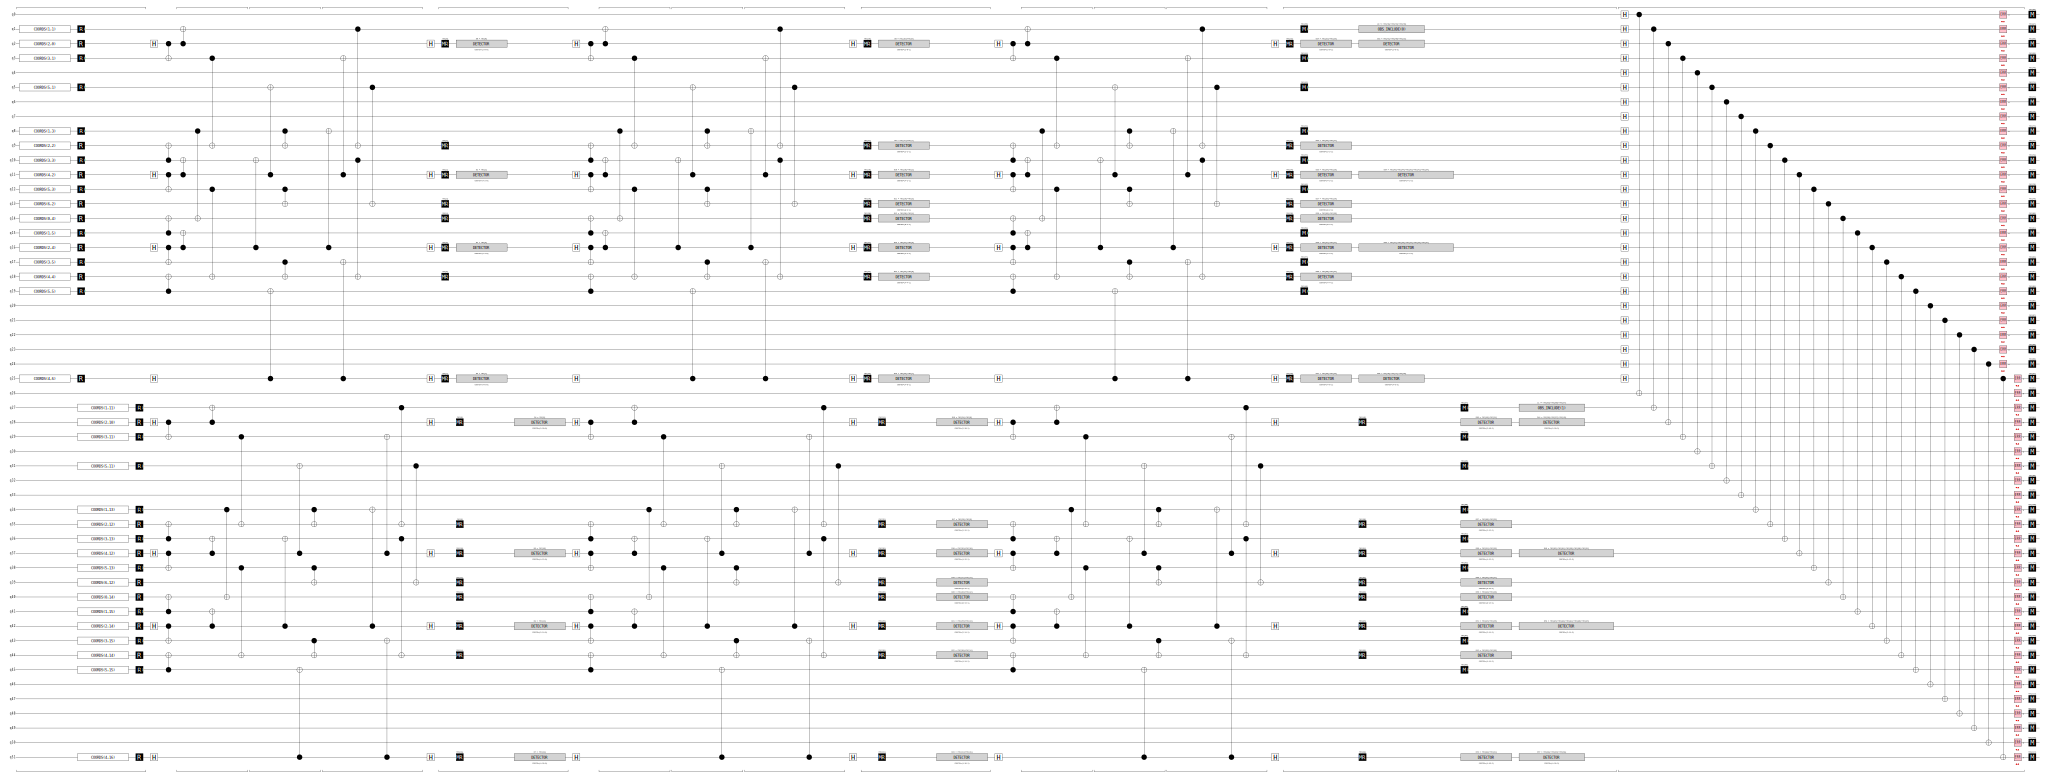

In [21]:
combined_clean.diagram('timeline-svg')

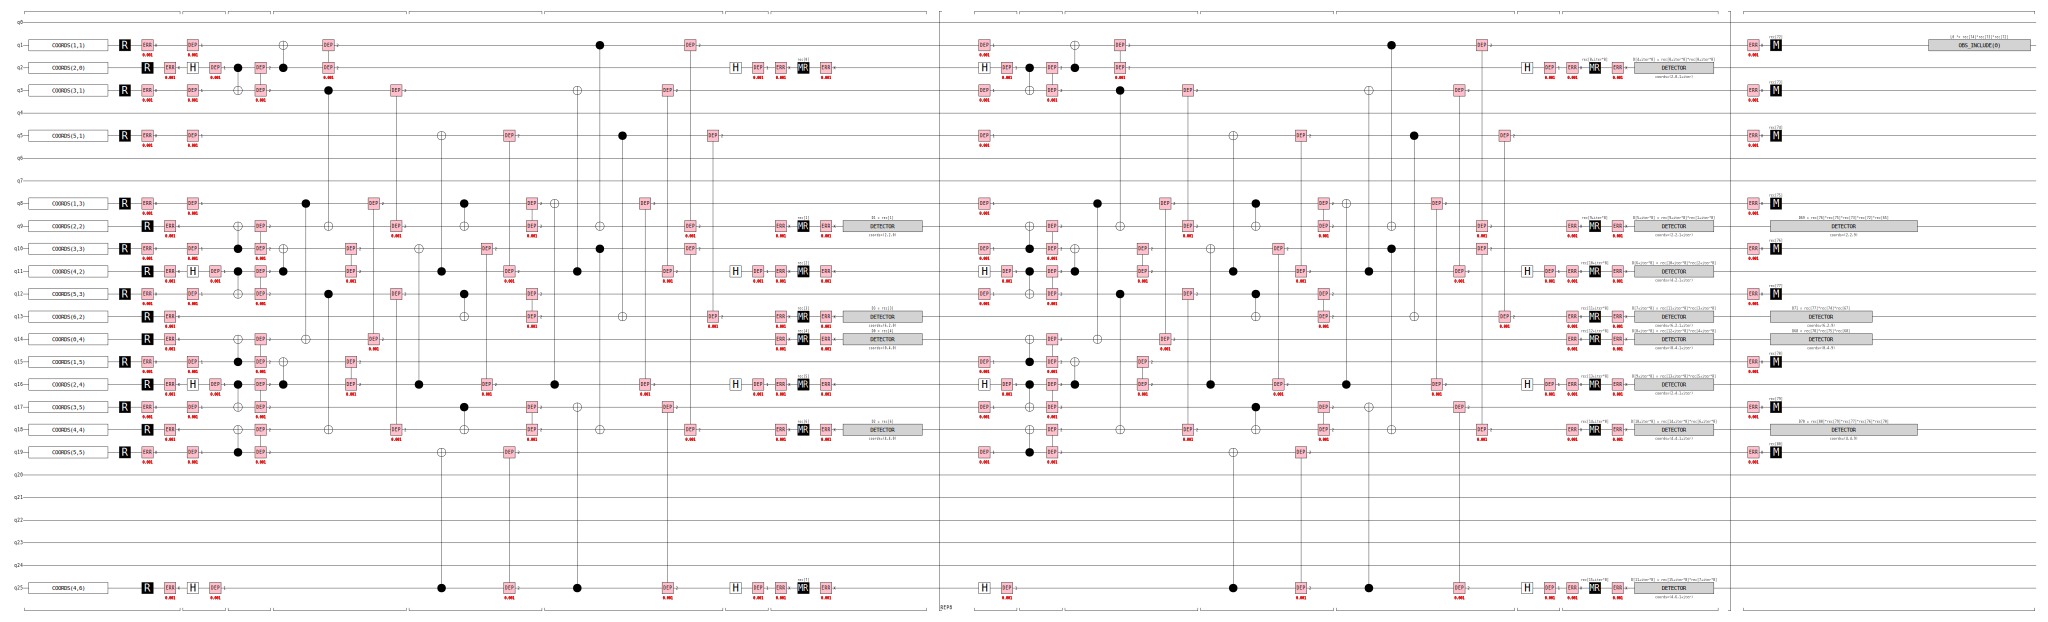

In [ ]:
# For initialization error use something like this instead:
d = 3
noise = 1e-3
c = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        )
c.diagram('timeline-svg')